In [4]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy .stats import pearsonr
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter, butter, filtfilt

In [5]:
def explore_hdf5(file_path):
    """
    Recursively explore the structure of an HDF5 file (.mat v7.3 format).
    
    Parameters:
        file_path (str): Path to the HDF5 (.mat) file.
    """
    def print_hdf5_structure(name, obj):
        print(f"{name}: {obj}")

    with h5py.File(file_path, 'r') as mat_file:
        print(f"Structure of {file_path}:")
        mat_file.visititems(print_hdf5_structure)

def get_hdf5_variable(file_path, variable_path):
    """
    Access a variable in an HDF5 file, even if nested.

    Parameters:
        file_path (str): Path to the HDF5 file.
        variable_path (str): Full path to the variable within the file (e.g., "group/subgroup/variable").
        
    Returns:
        np.array: The signal data.
    """
    with h5py.File(file_path, 'r') as mat_file:
        obj = mat_file
        for part in variable_path.split('/'):
            obj = obj[part]
        return np.array(obj).squeeze() 

pid_signal_file = r"C:\\Users\\amirr\\Py\\AP\\PID_EB50_Plume_014_1.mat"
sensor_signal_file = r"C:\\Users\\amirr\\Py\\AP\\MICS_EB50_Plume_014_1.mat"

print("Exploring PID Signal File:")
explore_hdf5(pid_signal_file)

print("\nExploring Sensor Signal File:")
explore_hdf5(sensor_signal_file)


Exploring PID Signal File:
Structure of C:\\Users\\amirr\\Py\\AP\\PID_EB50_Plume_014_1.mat:
PID_EB50_Plume_014_1__1__Ch1: <HDF5 group "/PID_EB50_Plume_014_1__1__Ch1" (9 members)>
PID_EB50_Plume_014_1__1__Ch1/comment: <HDF5 dataset "comment": shape (2,), type "<u8">
PID_EB50_Plume_014_1__1__Ch1/interval: <HDF5 dataset "interval": shape (1, 1), type "<f8">
PID_EB50_Plume_014_1__1__Ch1/length: <HDF5 dataset "length": shape (1, 1), type "<f8">
PID_EB50_Plume_014_1__1__Ch1/offset: <HDF5 dataset "offset": shape (1, 1), type "<f8">
PID_EB50_Plume_014_1__1__Ch1/scale: <HDF5 dataset "scale": shape (1, 1), type "<f8">
PID_EB50_Plume_014_1__1__Ch1/start: <HDF5 dataset "start": shape (1, 1), type "<f8">
PID_EB50_Plume_014_1__1__Ch1/title: <HDF5 dataset "title": shape (5, 1), type "<u2">
PID_EB50_Plume_014_1__1__Ch1/units: <HDF5 dataset "units": shape (5, 1), type "<u2">
PID_EB50_Plume_014_1__1__Ch1/values: <HDF5 dataset "values": shape (1, 561554), type "<f8">
PID_EB50_Plume_014_1__1__Ch2: <HDF5 g

In [6]:
# Variable paths for PID, sensor, and their respective trigger channels
pid_variable_path = 'PID_EB50_Plume_014_1__1__Ch4/values'  
sensor_variable_path = 'MICS_EB50_Plume_014_1__1__Ch5/values'  
pid_trigger_variable_path = 'PID_EB50_Plume_014_1__1__Ch8/values'
sensor_trigger_variable_path = 'MICS_EB50_Plume_014_1__1__Ch8/values'

# Load signals
pid_signal = get_hdf5_variable(pid_signal_file, pid_variable_path)
sensor_signal = get_hdf5_variable(sensor_signal_file, sensor_variable_path)
pid_trigger_signal = get_hdf5_variable(pid_signal_file, pid_trigger_variable_path)
sensor_trigger_signal = get_hdf5_variable(sensor_signal_file, sensor_trigger_variable_path)

# Sampling rate
sampling_rate = 10000 


In [7]:
# Identify trigger spikes for PID and MICS (threshold-based detection)
pid_trigger_threshold = 0.8 * np.max(pid_trigger_signal)
sensor_trigger_threshold = 0.8 * np.max(sensor_trigger_signal)

pid_trigger_spikes = np.where(pid_trigger_signal > pid_trigger_threshold)[0]
sensor_trigger_spikes = np.where(sensor_trigger_signal > sensor_trigger_threshold)[0]

#Low pass filter and baseline corrction
def low_pass_filter(signal, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)



sensor_signal_LPF = low_pass_filter(sensor_signal, 2200, sampling_rate)
# sensor_signal_pr = gaussian_filter1d(sensor_signal_LPF, sigma=2) 
# Correct the baseline of the sensor signal
# sensor_signal_corrected = correct_baseline(sensor_signal_pr, threshold_ratio=0.23)
sensor_signal_corrected = sensor_signal_LPF

# Define kernel function
def kernel(t, tau1, tau2):
    return np.exp(-t / tau1) - np.exp(-t / tau2) #tau1 - decay, tau2 - rise

def kernel_MOX(t, tau1, tau2, tau3, tau4):
    return (1/(t*tau1 +1))*np.exp(-t / tau3) - (1/(t*tau2+1))*np.exp(-t / tau4) #tau1 - decay, tau2 - rise


tau1, tau2 = 1 , 0.05
# tau1, tau2, tau3, tau4 = 14,2 ,1, 0.05	#KMOX
kernel_time = np.linspace(0, 1, len(sensor_signal_corrected))
kernel_signal = kernel(kernel_time, tau1, tau2)
# kernel_signal = kernel_MOX(kernel_time, tau1, tau2, tau3, tau4)

# FFT of the sensor signal and kernel
fft_sensor = np.fft.fft(sensor_signal_corrected)
fft_kernel = np.fft.fft(kernel_signal, n=len(sensor_signal))

# Deconvolution
fft_deconvolved = fft_sensor / (fft_kernel + 1e-10)  # Avoid division by zero
deconvolved_signal = np.fft.ifft(fft_deconvolved).real

# Normalize signals
sensor_signal_normalized = sensor_signal / np.max(np.abs(sensor_signal))
deconvolved_signal_normalized = deconvolved_signal / np.max(np.abs(deconvolved_signal))
pid_signal_normalized = pid_signal / np.max(np.abs(pid_signal))

# Smooth deconvolved signal
window_size = 10
deconvolved_signal_smoothed = gaussian_filter1d(deconvolved_signal_normalized, sigma=9)  # Adjust sigma for smoothing strength
# deconvolved_signal_smoothed = np.convolve(deconvolved_signal_normalized, np.ones(window_size)/window_size, mode='same')
# deconvolved_signal_smoothed = savgol_filter(deconvolved_signal_normalized, window_length=51, polyorder=2)

# Center and calibrate signals
pid_signal_centered = pid_signal_normalized - np.mean(pid_signal_normalized)
deconvolved_signal_centered = deconvolved_signal_smoothed - np.mean(deconvolved_signal_smoothed)
scaling_factor = np.max(np.abs(pid_signal_centered)) / np.max(np.abs(deconvolved_signal_centered))
deconvolved_signal_calibrated = deconvolved_signal_centered * scaling_factor


In [8]:
def correct_baseline(signal, threshold_ratio=0.2):
    """
    Corrects the baseline of a signal by subtracting the average value 
    of the signal below a specified threshold.

    Parameters:
        signal (np.array): Input signal to correct.
        threshold_ratio (float): Ratio of max(signal) to define the baseline threshold.

    Returns:
        np.array: Signal with corrected baseline.
    """
    # Define the threshold
    threshold = threshold_ratio * np.max(signal)
    
    # Identify values below the threshold
    low_values = signal[signal < threshold]

    # Calculate the average of low values
    baseline = np.mean(low_values) if len(low_values) > 0 else 0
    
    # Subtract the baseline from the signal and remove negative values
    # corrected_signal = np.maximum((signal - baseline), 0)
    corrected_signal = signal - baseline
    return corrected_signal

deconvolved_signal_calibrated_corrected = correct_baseline(deconvolved_signal_calibrated, threshold_ratio=0.2)

In [9]:
# Parameters
trigger_threshold = 0.8
trigger_duration = 2  # seconds
offset = 0.01  # offset after trigger
Tmax = 0.7

# File paths
output_folder = r"C:\Users\amirr\Py\AP\Output"

# Deduplicate trigger indices for PID and sensor
pid_trigger_indices = np.where(pid_trigger_signal > trigger_threshold)[0]
pid_deduplicated_indices = [pid_trigger_indices[0]] + [
    idx for i, idx in enumerate(pid_trigger_indices[1:]) if idx - pid_trigger_indices[i] > int(0.1 * sampling_rate)
]

sensor_trigger_indices = np.where(sensor_trigger_signal > trigger_threshold)[0]
sensor_deduplicated_indices = [sensor_trigger_indices[0]] + [
    idx for i, idx in enumerate(sensor_trigger_indices[1:]) if idx - sensor_trigger_indices[i] > int(0.1 * sampling_rate)
]

samples_to_include = int(trigger_duration * sampling_rate)
offset_samples = int(offset * sampling_rate)


In [10]:
# Extract repeats for PID signals
pid_repeats = {
    f"repeat_{i + 1}": pid_signal_centered[idx + offset_samples:idx + offset_samples + samples_to_include]
    for i, idx in enumerate(pid_deduplicated_indices)
    if idx + offset_samples + samples_to_include <= len(pid_signal)
}

# Extract repeats for deconvolved signals
deconvolved_repeats = {
    f"repeat_{i + 1}": deconvolved_signal_calibrated[idx + offset_samples:idx + offset_samples + samples_to_include]
    for i, idx in enumerate(sensor_deduplicated_indices)
    if idx + offset_samples + samples_to_include <= len(deconvolved_signal_calibrated)
}

# Normalize repeats
pid_normalized_repeats = {
    key: (data - np.min(data)) / (np.max(data) - np.min(data)) for key, data in pid_repeats.items()
}
deconvolved_normalized_repeats = {
    key: (data - np.min(data)) / (np.max(data) - np.min(data)) for key, data in deconvolved_repeats.items()
}

# Correlations between each pair of PID and MICS repeats
correlations_pid_mics = {
    (pid_key, mics_key): pearsonr(pid_normalized_repeats[pid_key][:len(deconvolved_normalized_repeats[mics_key])],
                                  deconvolved_normalized_repeats[mics_key][:len(pid_normalized_repeats[pid_key])])[0]
    for pid_key in pid_normalized_repeats.keys() 
    for mics_key in deconvolved_normalized_repeats.keys()
}

# Calculate correlations between the first repeat of each signal
reference_pid_signal = list(pid_repeats.values())[0]  # Use the first PID repeat as reference
reference_pid_normalized = (reference_pid_signal - np.min(reference_pid_signal)) / (np.max(reference_pid_signal) - np.min(reference_pid_signal))

correlations_with_first = {
    key: pearsonr(data[:len(reference_pid_normalized)], reference_pid_normalized[:len(data)])[0]
    for key, data in deconvolved_normalized_repeats.items()
}


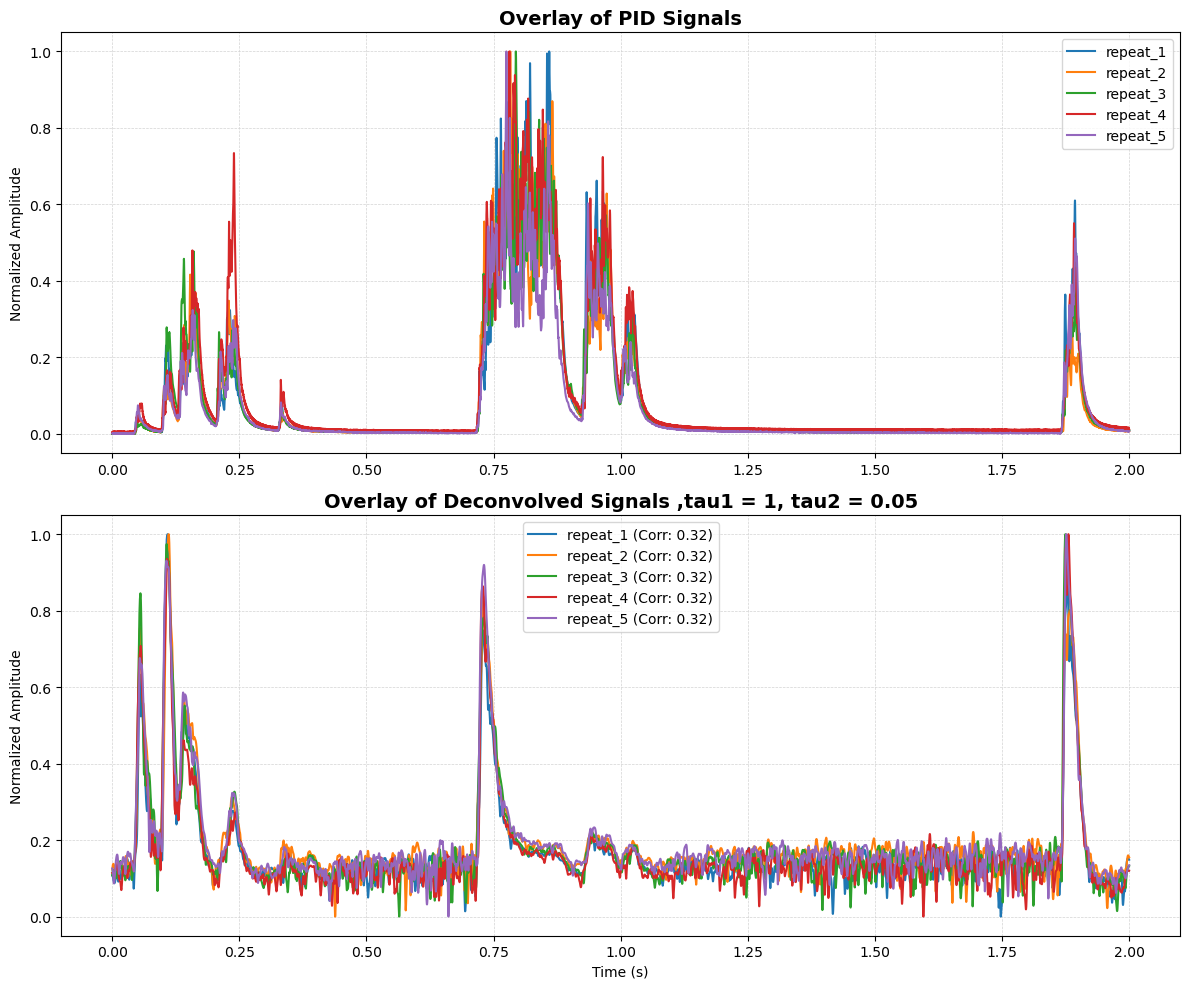

In [11]:
# Time axis for plotting
time = np.arange(samples_to_include) / sampling_rate

# Plot 1: Overlay of PID and deconvolved signals
fig1, axs = plt.subplots(2, 1, figsize=(12, 10))
for key, data in pid_normalized_repeats.items():
    axs[0].plot(time, data, label=f"{key}", linewidth=1.5)
axs[0].set_title(f"Overlay of PID Signals", fontsize=14, fontweight='bold')
axs[0].set_ylabel("Normalized Amplitude")
axs[0].legend(fontsize=10, loc="upper right")
axs[0].grid(color='lightgrey', linestyle='--', linewidth=0.5)

for key, data in deconvolved_normalized_repeats.items():
    axs[1].plot(time, data, label=f"{key} (Corr: {correlations_pid_mics.get((list(pid_normalized_repeats.keys())[0], key), 'N/A'):.2f})")
axs[1].set_title(f"Overlay of Deconvolved Signals ,tau1 = {tau1}, tau2 = {tau2}", fontsize=14, fontweight='bold')
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Normalized Amplitude")
axs[1].legend(fontsize=10)
axs[1].grid(color='lightgrey', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(output_folder, f"PID_vs_Deconvolved_TMax_{Tmax}_Overlay_gau5.png"), dpi=300)
plt.show()


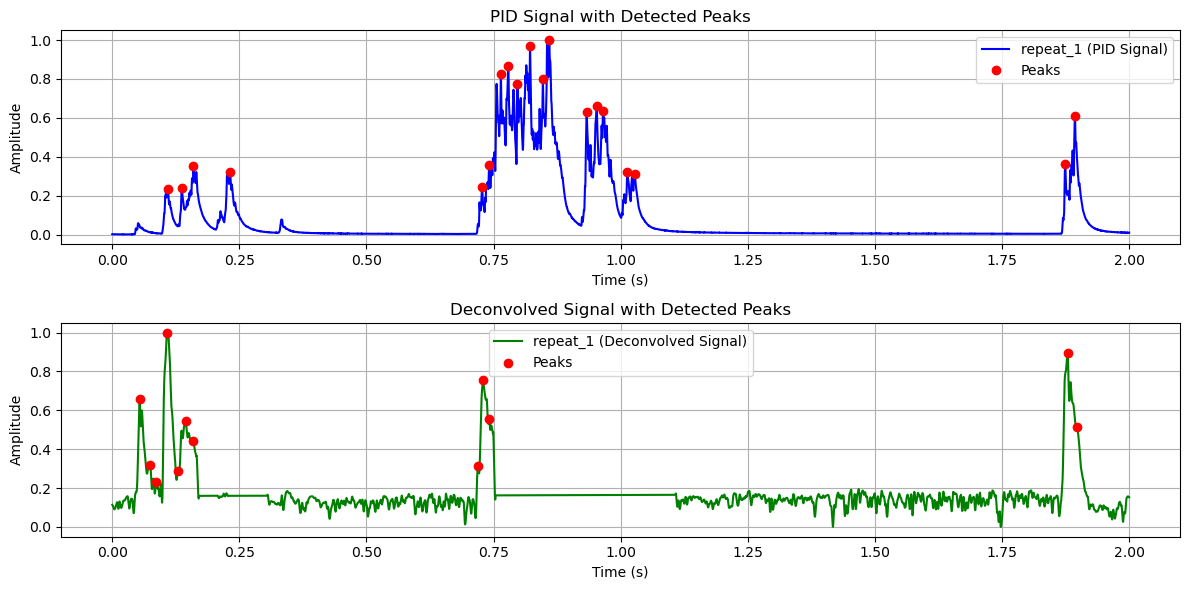

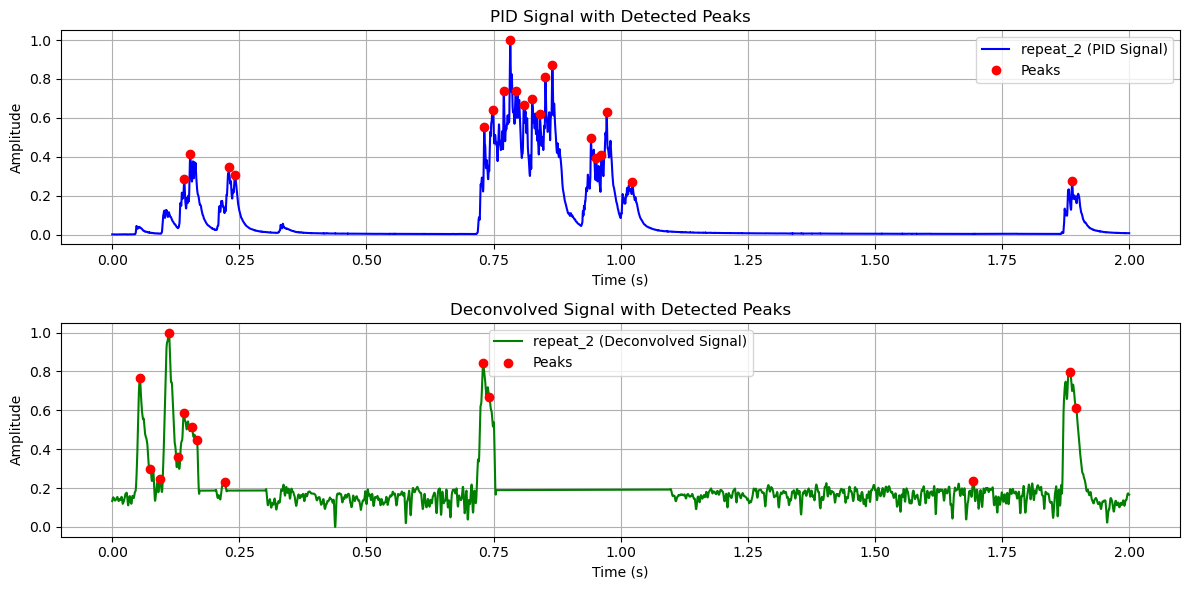

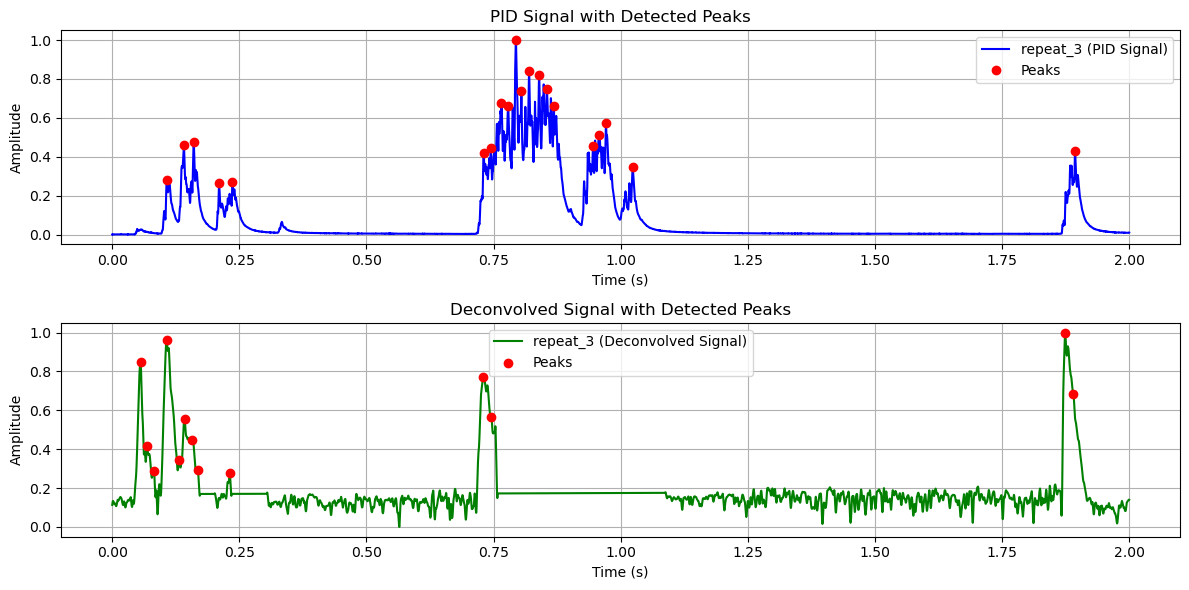

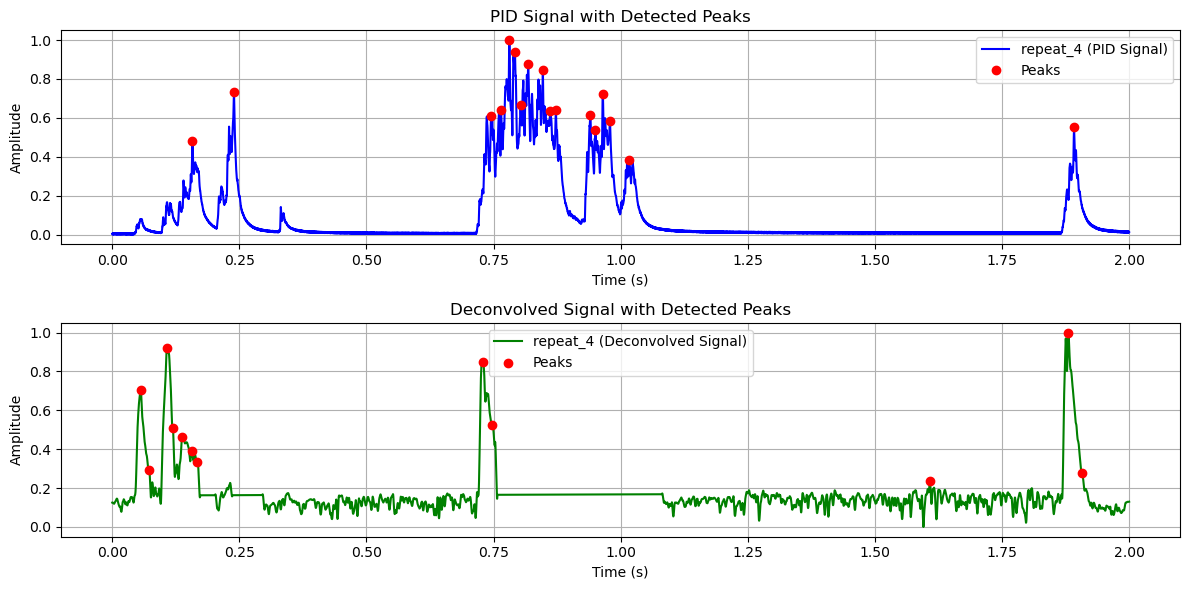

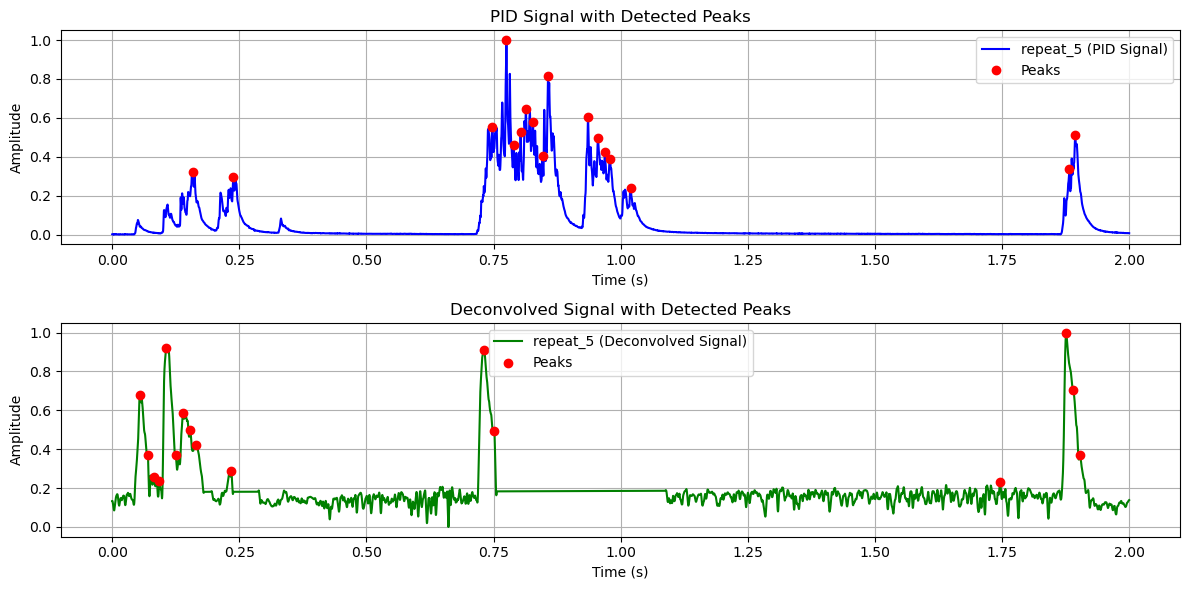

In [46]:
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Set thresholds
min_peak_height = 0.23  # Minimum height of peaks
min_peak_distance = int(0.01 * sampling_rate)  # Minimum distance between peaks in samples
prominance_value = 0.1

# Function to detect and plot peaks for each repeat
def plot_with_peaks(pid_repeats, deconvolved_repeats, time_axis, save_folder=None):
    """
    Plot PID and Deconvolved signals with detected peaks for each repeat.

    Parameters:
        pid_repeats (dict): Dictionary of PID signal repeats.
        deconvolved_repeats (dict): Dictionary of deconvolved signal repeats.
        time_axis (np.array): Time axis for plotting.
        save_folder (str): Path to save the plots (optional).
    """
    for i, (pid_key, pid_data) in enumerate(pid_repeats.items()):
        deconvolved_key = list(deconvolved_repeats.keys())[i]
        deconvolved_data = deconvolved_repeats[deconvolved_key]

        # Detect peaks in PID and Deconvolved signals
        pid_peaks, _ = find_peaks(pid_data, height=min_peak_height, distance=min_peak_distance,prominence= prominance_value)
        deconvolved_peaks, _ = find_peaks(deconvolved_data, height=min_peak_height, distance=min_peak_distance)

        # Plot signals with peaks
        plt.figure(figsize=(12, 6))

        # PID Signal
        plt.subplot(2, 1, 1)
        plt.plot(time_axis, pid_data, label=f"{pid_key} (PID Signal)", color='blue')
        plt.plot(time_axis[pid_peaks], pid_data[pid_peaks], "ro", label="Peaks")
        plt.title("PID Signal with Detected Peaks")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid()

        # Deconvolved Signal
        plt.subplot(2, 1, 2)
        plt.plot(time_axis, deconvolved_data, label=f"{deconvolved_key} (Deconvolved Signal)", color='green')
        plt.plot(time_axis[deconvolved_peaks], deconvolved_data[deconvolved_peaks], "ro", label="Peaks")
        plt.title("Deconvolved Signal with Detected Peaks")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.grid()

        # Save or show the plot
        plt.tight_layout()
        if save_folder:
            plt.savefig(f"{save_folder}/Repeat_{i + 1}_Peaks.png", dpi=300)
        else:
            plt.show()
time_axis = np.arange(len(next(iter(pid_normalized_repeats.values())))) / sampling_rate

# Call the function to plot each repeat
plot_with_peaks(pid_normalized_repeats, deconvolved_normalized_repeats, time_axis)

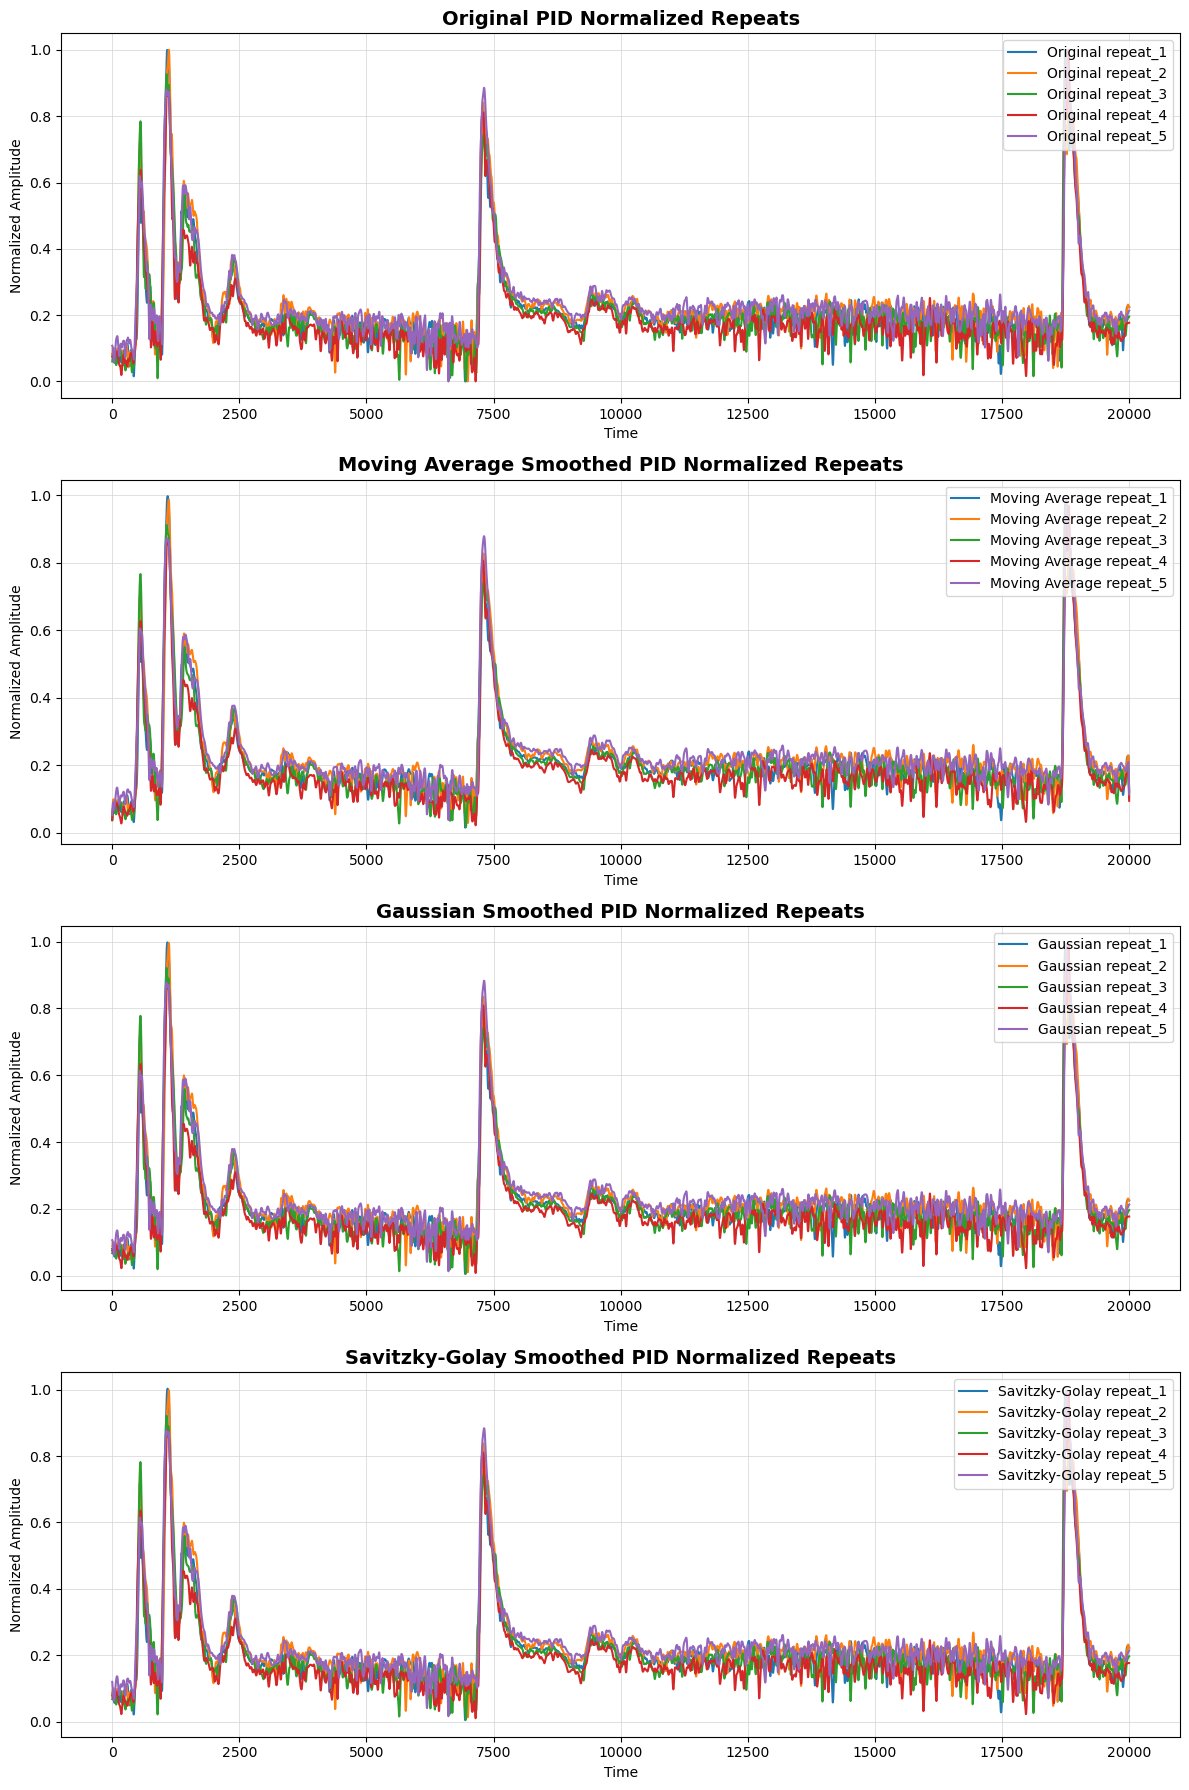

<Figure size 640x480 with 0 Axes>

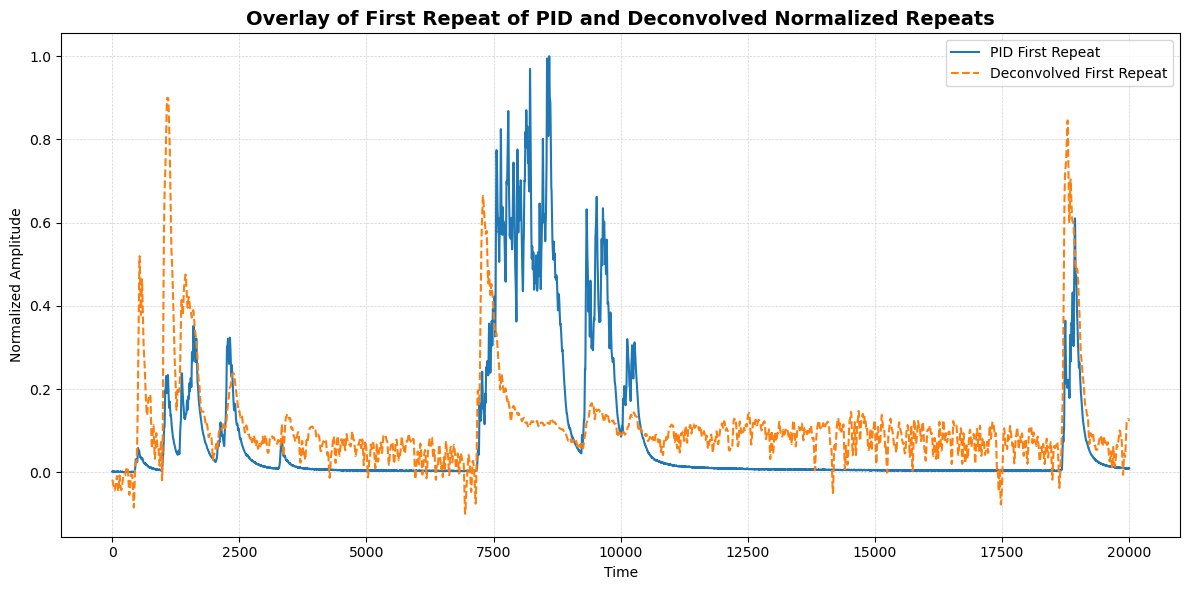

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from datetime import datetime
import os

# Example data (replace with your actual data)
# pid_normalized_repeats = {
#     "repeat_1": np.random.rand(1000),
#     "repeat_2": np.random.rand(1000)
# }

# Define smoothing functions
def moving_average(signal, window_size):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='same')

def gaussian_smoothing(signal, sigma):
    return gaussian_filter1d(signal, sigma=sigma)

def savgol_smoothing(signal, window_length, polyorder):
    return savgol_filter(signal, window_length=window_length, polyorder=polyorder)

# Parameters for smoothing
window_size = 30  # Moving average window size
sigma = 5  # Gaussian filter sigma
window_length = 51  # Savitzky-Golay filter window length
polyorder = 2  # Savitzky-Golay filter polynomial order

# Apply smoothing functions to each repeat in pid_normalized_repeats
pid_smoothed_moving_average = {key: moving_average(data, window_size) for key, data in deconvolved_normalized_repeats.items()}
pid_smoothed_gaussian = {key: gaussian_smoothing(data, sigma) for key, data in deconvolved_normalized_repeats.items()}
pid_smoothed_savgol = {key: savgol_smoothing(data, window_length, polyorder) for key, data in deconvolved_normalized_repeats.items()}

# Time axis for plotting
time = np.arange(len(next(iter(deconvolved_normalized_repeats.values()))))  # Adjust time axis as needed

# Plot original and smoothed PID normalized repeats in four subplots
fig, axs = plt.subplots(4, 1, figsize=(12, 18))

# Plot original PID normalized repeats
for key, data in deconvolved_normalized_repeats.items():
    axs[0].plot(time, data, label=f"Original {key}", linewidth=1.5)
axs[0].set_title("Original PID Normalized Repeats", fontsize=14, fontweight='bold')
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Normalized Amplitude")
axs[0].legend(fontsize=10, loc="upper right")
axs[0].grid(color='lightgrey', linestyle='solid', linewidth=0.5)

# Plot moving average smoothed PID normalized repeats
for key, data in pid_smoothed_moving_average.items():
    axs[1].plot(time, data, label=f"Moving Average {key}", linestyle='-', linewidth=1.5)
axs[1].set_title("Moving Average Smoothed PID Normalized Repeats", fontsize=14, fontweight='bold')
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Normalized Amplitude")
axs[1].legend(fontsize=10, loc="upper right")
axs[1].grid(color='lightgrey', linewidth=0.5)

# Plot Gaussian smoothed PID normalized repeats
for key, data in pid_smoothed_gaussian.items():
    axs[2].plot(time, data, label=f"Gaussian {key}", linestyle='-', linewidth=1.5)
axs[2].set_title("Gaussian Smoothed PID Normalized Repeats", fontsize=14, fontweight='bold')
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Normalized Amplitude")
axs[2].legend(fontsize=10, loc="upper right")
axs[2].grid(color='lightgrey', linestyle ='solid' ,linewidth=0.5)

# Plot Savitzky-Golay smoothed PID normalized repeats
for key, data in pid_smoothed_savgol.items():
    axs[3].plot(time, data, label=f"Savitzky-Golay {key}", linestyle='-', linewidth=1.5)
axs[3].set_title("Savitzky-Golay Smoothed PID Normalized Repeats", fontsize=14, fontweight='bold')
axs[3].set_xlabel("Time")
axs[3].set_ylabel("Normalized Amplitude")
axs[3].legend(fontsize=10, loc="upper right")
axs[3].grid(color='lightgrey', linestyle ='solid', linewidth=0.5)

plt.tight_layout()

# Generate a unique filename using a timestamp
output_folder = "output"  # Replace with your actual output folder
Tmax = 100  # Replace with your actual Tmax value
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"PID_Smoothing_TMax_{Tmax}_{timestamp}.png"

# Save the plot
plt.savefig(os.path.join(output_folder, filename), dpi=300)
plt.show()


# Generate a unique filename using a timestamp
output_folder = "output"  # Replace with your actual output folder
Tmax = 100  # Replace with your actual Tmax value
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"PID_Smoothing_TMax_{Tmax}_{timestamp}.png"

# Save the plot
plt.savefig(os.path.join(output_folder, filename), dpi=300)
plt.show()

# Plot first repeat of PID and deconvolved normalized repeats
fig, ax = plt.subplots(figsize=(12, 6))

# Extract the first repeat
pid_first_repeat = pid_normalized_repeats["repeat_1"]
deconvolved_first_repeat = deconvolved_normalized_repeats["repeat_1"]-0.1

# Plot the first repeat of PID and deconvolved normalized repeats
ax.plot(time, pid_first_repeat, label="PID First Repeat", linestyle='-', linewidth=1.5)
ax.plot(time, deconvolved_first_repeat, label="Deconvolved First Repeat", linestyle='--', linewidth=1.5)

ax.set_title("Overlay of First Repeat of PID and Deconvolved Normalized Repeats", fontsize=14, fontweight='bold')
ax.set_xlabel("Time")
ax.set_ylabel("Normalized Amplitude")
ax.legend(fontsize=10, loc="upper right")
ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)

plt.tight_layout()

# Generate a unique filename using a timestamp for the overlay plot
filename_overlay = f"PID_vs_Deconvolved_First_Repeat_TMax_{Tmax}_{timestamp}.png"

# Save the overlay plot
plt.savefig(os.path.join(output_folder, filename_overlay), dpi=300)
plt.show()